## Keras + autoencoder to handle passbands as timeseries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
import time
import tensorflow as tf
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import GRU, Dense, Activation, Dropout, CuDNNGRU, concatenate, Input
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.models import Sequential, Model
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import matplotlib.pyplot as plt

import pac_autoencoder as pac_ae
import pac_dataset as pac_data

from importlib import reload 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
ROOT_PATH = "/media/hayk/ecf060ce-bc56-4885-9176-43d514db6c66/pac"

import os
print(os.listdir(ROOT_PATH))

# Any results you write to the current directory are saved as output.

['test_set.csv.zip', 'sample_submission.csv.zip', 'sample_submission.csv', 'test_set_sample.csv', 'test_set_metadata.csv', 'test_set_metadata.csv.zip', 'test_set_sample.csv.zip', 'training_set_metadata.csv', 'data_note.pdf', 'training_set.csv', 'fake030.csv', 'fake010.csv', 'data_note.pdf.zip', 'training_set.csv.zip', 'test_set.csv']


In [3]:
train_metadata = pd.read_csv('predictions.csv')


In [4]:
train_metadata.shape

(3492890, 16)

# Load Data

In [5]:
# load metadata
train_metadata = pd.read_csv(os.path.join(ROOT_PATH, 'training_set_metadata.csv'))

# load light data
train_data = pd.read_csv(os.path.join(ROOT_PATH, 'training_set.csv'))

# load test metadata
#test_metadata = pd.read_csv(os.path.join(ROOT_PATH, 'test_set_metadata.csv'))

# load light data
#test_data = pd.read_csv(os.path.join(ROOT_PATH, 'test_set.csv'))


# Preprocessing Data

In [6]:
prep_train_data = pac_data.prep_data(data=train_data)

In [7]:
prep_train_data.head()

object_id       mjd  passband      flux  flux_err  detected
0        615 -0.688597         2 -0.451118 -0.947158       1.0
1        615 -0.688583         1 -0.469921 -0.310105       1.0
2        615 -0.688569         3 -0.444594 -0.940782       1.0
3        615 -0.688557         4 -0.436097 -0.228954       1.0
4        615 -0.684971         2 -0.461443 -0.930153       1.0

In [8]:
prep_train_data.groupby(["passband", "object_id"]).mjd.describe()

count      mean       std       min       25%       50%  \
passband object_id                                                            
0        615         63.0  0.277325  0.506434 -0.562985  0.026542  0.195239   
         713         70.0  0.344830  0.554872 -0.504415 -0.347015  0.302216   
         730         72.0  0.220231  0.580270 -0.564592 -0.400946  0.247378   
         745         72.0  0.220303  0.523409 -0.564687 -0.399118  0.185189   
         1124        63.0  0.277325  0.506434 -0.562985  0.026542  0.195239   
         1227        72.0  0.220231  0.580270 -0.564592 -0.400946  0.247378   
         1598        63.0  0.277325  0.506434 -0.562985  0.026542  0.195239   
         1632        63.0  0.277325  0.506434 -0.562985  0.026542  0.195239   
         1920        30.0 -0.301335  0.499986 -0.995808 -0.776660 -0.182106   
         1926        30.0 -0.301335  0.499986 -0.995808 -0.776660 -0.182106   
         2072        72.0  0.220303  0.523409 -0.564687 -0.399118  0.185189   
         2103        63.0  0.277325  0.506434 -0.562985  0.026542  0.195239   
         2300        72.0  0.220303  0.523409 -0.564687 -0.399118  0.185189   
         2330        72.0  0.220303  0.523409 -0.564687 -0.399118  0.185189   
         2624        63.0  0.277325  0.506434 -0.562985  0.026542  0.195239   
         2677        70.0  0.344830  0.554872 -0.504415 -0.347015  0.302216   
         2922        63.0  0.277325  0.506434 -0.562985  0.026542  0.195239   
         3041        63.0  0.277325  0.506434 -0.562985  0.026542  0.195239   
         3285        30.0 -0.301335  0.499986 -0.995808 -0.776660 -0.182106   
         3423        63.0  0.277325  0.506434 -0.562985  0.026542  0.195239   
         3489        30.0 -0.301335  0.499986 -0.995808 -0.776660 -0.182106   
         3910        72.0  0.220303  0.523409 -0.564687 -0.399118  0.185189   
         4088        72.0  0.220303  0.523409 -0.564687 -0.399118  0.185189   
         4132        72.0  0.220303  0.523409 -0.564687 -0.399118  0.185189   
         4171        72.0  0.220303  0.523409 -0.564687 -0.399118  0.185189   
         4173        30.0 -0.301335  0.499986 -0.995808 -0.776660 -0.182106   
         4220        72.0  0.220303  0.523409 -0.564687 -0.399118  0.185189   
         4389        30.0 -0.301335  0.499986 -0.995808 -0.776660 -0.182106   
         4595        63.0  0.277325  0.506434 -0.562985  0.026542  0.195239   
         4819        72.0  0.220231  0.580270 -0.564592 -0.400946  0.247378   
...                   ...       ...       ...       ...       ...       ...   
5        130219752   27.0  0.018835  0.571970 -0.657878 -0.567553  0.003785   
         130231675   44.0  0.215748  0.548697 -0.593813 -0.345250  0.266581   
         130263372   41.0 -0.032307  0.606196 -0.999966 -0.487856 -0.155734   
         130312781   43.0 -0.056039  0.644010 -0.985159 -0.756009 -0.159243   
         130319749   37.0  0.224523  0.580555 -0.648486 -0.382256  0.255532   
         130330088   35.0  0.124646  0.563096 -0.657910 -0.471867  0.102179   
         130359176   36.0 -0.118145  0.615396 -0.983351 -0.760129 -0.161999   
         130375489   35.0  0.119788  0.588406 -0.652190 -0.474637  0.001953   
         130386135   34.0  0.136535  0.547557 -0.597216 -0.354855  0.084128   
         130402542   21.0 -0.005939  0.616752 -0.853719 -0.381788 -0.047968   
         130408188   25.0  0.067266  0.534468 -0.648413 -0.490042 -0.005590   
         130414189   39.0  0.266622  0.550987 -0.597460 -0.266180  0.210001   
         130489916   31.0 -0.174018  0.506843 -0.868203 -0.623437 -0.215706   
         130552230   33.0  0.104382  0.566883 -0.981718 -0.360321  0.164479   
         130595291   28.0  0.043115  0.586248 -0.760148 -0.531299 -0.024581   
         130617044   41.0  0.082071  0.606540 -0.985239 -0.360316  0.208331   
         130622528   44.0 -0.111628  0.631300 -0.985139 -0.770641 -0.162833   
         130639669   39.0 -0.156032  0.601251 -0.985091 -0.782377 -0.2

In [9]:
prep_train_data.groupby(["passband"]).flux_err.describe()

count      mean       std       min       25%       50%  \
passband                                                               
0         197493.0 -0.686845  0.367821 -0.995679 -0.982962 -0.969260   
1         176499.0 -0.886549  0.249583 -1.000000 -0.993130 -0.981435   
2         238049.0 -0.808538  0.304359 -0.999496 -0.990505 -0.972292   
3         233520.0 -0.658637  0.355434 -0.996144 -0.983042 -0.935296   
4         277119.0 -0.501667  0.367953 -0.990424 -0.967035 -0.239536   
5         299025.0 -0.242479  0.168258 -0.953522 -0.274298 -0.184749   

               75%       max  
passband                      
0        -0.246142  1.000000  
1        -0.963600  0.393745  
2        -0.900419  0.215522  
3        -0.271720  0.213019  
4        -0.208161  0.223191  
5        -0.158633  0.242071

In [10]:
prep_train_data.detected.describe()

count    1.421705e+06
mean    -6.667663e-01
std      7.452671e-01
min     -1.000000e+00
25%     -1.000000e+00
50%     -1.000000e+00
75%     -1.000000e+00
max      1.000000e+00
Name: detected, dtype: float64

In [11]:
#train_data.groupby(["object_id"]).flux.describe()
#np.min(train.flux_err.values)

# Magical transformation
As you see above, train data can be grouped by object_id, passband, list of [flux] order by mjd.

Meaning 1 train input row would be<br>
``
object_id = 615, passband=1, flux0 = 0.228287, flux1 = xxx, ... flux72 = xxx
``

Similary we can have similar row for flux_err.<br>
``
object_id = 615, passband=1, flux_err0 = 0.0.005226, flux_err = xxx, ... flux_err = xxx
``

The following methods do the transformation!

As you can see the shapes above, each passband __may have__ different length of time series. eg) passband0 has len = 75, but passband1 = 61.

#### Transform for AUTOENCODER input
 Input to AUTOENCODER is (batch_size, timesteps, input_dim).
 - batch_size is batch_size :)
 - timesteps is 75 for passband0, (we will take maximum of 6 and pad with 0 the rest)
 - input_dim is number of feature the timeseries has, here we have 4 ['mjd', 'flux', 'flux_err', 'detected'].

In [12]:
net_input_data = pac_data.prep_for_net_input(prep_train_data)

train_list[0] (31392, 75)
train_list[1] (31392, 61)
train_list[2] (31392, 61)
train_list[3] (31392, 61)
train_list[4] (31392, 61)
train_list[5] (31392, 60)
[31392    75]
num_columns[0]: 72
X_train_list[0].shape: (7848, 72, 4)
num_columns[1]: 58
X_train_list[1].shape: (7848, 58, 4)
num_columns[2]: 58
X_train_list[2].shape: (7848, 58, 4)
num_columns[3]: 58
X_train_list[3].shape: (7848, 58, 4)
num_columns[4]: 58
X_train_list[4].shape: (7848, 58, 4)
num_columns[5]: 57
X_train_list[5].shape: (7848, 57, 4)
(7848, 72, 4)
(7848, 72, 4)
(7848, 72, 4)
(7848, 72, 4)
(7848, 72, 4)
(7848, 72, 4)


In [13]:
net_input_data.X_train.shape

(7848, 72, 6, 4)

In [14]:
#X_train_tmp = X_train.reshape([-1,24])
#print(np.max(X_train_tmp, axis=0))
#np.min(X_train_tmp, axis=0)

## Get and construct labelsfrom metadata

In [15]:
#reload(pac_data)
train_list0 = net_input_data.train_list[0]
train_list0 = train_list0[train_list0.feature_id == 'flux']
label_info = pac_data.get_labels(metadata=train_metadata, train_data_with_object_id=train_list0)

### AUTO ENCODER begins here
Note that
- I'm using Keras functional API which supports multples inputs.

In [42]:
reload(pac_data)
reload(pac_ae)

ROOT_DIR = os.path.abspath("./")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

weight_table, _ = pac_data.get_weigth_table(classes=label_info.classes, target_map=label_info.target_map)
print(weight_table)
model = pac_ae.pac_autoencoder(model_dir=MODEL_DIR, weight_table=weight_table)
#model.load_weights(filepath="/home/hayk/kaggle/pac/logs/pac20181212T1144/pac_1_0343.h5")

[0.01924057 0.06307339 0.117737   0.15201325 0.02331804 0.00382263
 0.06167176 0.01299694 0.125      0.02650357 0.04714577 0.29472477
 0.03045362 0.02229867]
(?, 9, 6, 128)
u3 shape : (?, 72, 6, 64)
decoded shape : (?, 72, 6, 4)
descriminator d2 shape : (?, 18, 6, 128)
descriminator d3 shape : (?, 9, 6, 256)
descriminator validity shape : (?, 9, 6, 1)
(?, 72, 6, 4)
(?, 9, 6, 128)
classificator shape c2 : (?, 1, 1, 128)
classificator shape rc2 : (?, 128)
14


In [43]:
model.epoch

0

In [44]:
print(model.enc_shape)
model.dec_shape
model.adversarial_autoencoder.trainable_weights
model.discriminator._collected_trainable_weights
model.adversarial_autoencoder._collected_trainable_weights

[9, 6, 128]


[<tf.Variable 'encoder_e1_Conv2D_6/kernel:0' shape=(5, 1, 4, 32) dtype=float32_ref>,
 <tf.Variable 'encoder_e1_Conv2D_6/bias:0' shape=(32,) dtype=float32_ref>,
 <tf.Variable 'encoder_e1_INor_6/gamma:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'encoder_e1_INor_6/beta:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'encoder_e2_Conv2D_6/kernel:0' shape=(5, 1, 32, 64) dtype=float32_ref>,
 <tf.Variable 'encoder_e2_Conv2D_6/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'encoder_e2_INor_6/gamma:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'encoder_e2_INor_6/beta:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'encoder_e3_Conv2D_6/kernel:0' shape=(4, 4, 64, 128) dtype=float32_ref>,
 <tf.Variable 'encoder_e3_Conv2D_6/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'encoder_e3_INor_6/gamma:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'encoder_e3_INor_6/beta:0' shape=(1,) dtype=float32_ref>,
 <tf.Variable 'decoder_u1_Conv2D_6/kernel:0' shape=(3, 3, 128, 64) dtype=float32_

In [45]:
model.train(X=net_input_data.X_train, y_map=label_info.target_map, y_categorical=label_info.Y)

/home/hayk/kaggle/pac/.env/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.411177, acc: 35.45%] [G loss: 9.602543, mse: 0.689960, mywloss: 6.634088]
 Validation 
0 [D loss: 2.755519, acc: 25.25%] [G loss: 4.825517, mse: 0.689980, mywloss: 1.644590]
1 [D loss: 1.354968, acc: 36.86%] [G loss: 3.256743, mse: 0.799522, mywloss: 0.158235]
 Validation 
1 [D loss: 0.659471, acc: 66.16%] [G loss: 6.354311, mse: 0.806759, mywloss: 3.389625]
2 [D loss: 0.439580, acc: 64.09%] [G loss: 3.503873, mse: 0.785059, mywloss: 0.398827]
 Validation 
2 [D loss: 0.242699, acc: 69.45%] [G loss: 4.570420, mse: 0.815666, mywloss: 1.606984]
3 [D loss: 0.352086, acc: 68.40%] [G loss: 5.135422, mse: 0.690774, mywloss: 2.395221]
 Validation 
3 [D loss: 0.560536, acc: 54.01%] [G loss: 3.648316, mse: 0.662014, mywloss: 0.817656]
4 [D loss: 0.215254, acc: 79.92%] [G loss: 4.490464, mse: 0.664891, mywloss: 1.881413]
 Validation 
4 [D loss: 0.256015, acc: 71.20%] [G loss: 3.049853, mse: 0.688469, mywloss: 0.333310]
5 [D loss: 0.165128, acc: 78.17%] [G loss: 4.347236, mse: 0.70632

 Validation 
43 [D loss: 0.131475, acc: 85.08%] [G loss: 2.655560, mse: 0.220108, mywloss: 1.157223]
44 [D loss: 0.156270, acc: 77.23%] [G loss: 2.544281, mse: 0.227577, mywloss: 1.168673]
 Validation 
44 [D loss: 0.163232, acc: 75.25%] [G loss: 2.642495, mse: 0.228866, mywloss: 1.123387]
45 [D loss: 0.158256, acc: 78.02%] [G loss: 2.290176, mse: 0.228835, mywloss: 0.847651]
 Validation 
45 [D loss: 0.101407, acc: 89.47%] [G loss: 2.551373, mse: 0.238888, mywloss: 1.029306]
46 [D loss: 0.116575, acc: 85.50%] [G loss: 2.242393, mse: 0.206518, mywloss: 0.801250]
 Validation 
46 [D loss: 0.124734, acc: 83.35%] [G loss: 2.294630, mse: 0.214647, mywloss: 0.833670]
47 [D loss: 0.109278, acc: 86.17%] [G loss: 2.191689, mse: 0.215726, mywloss: 0.956896]
 Validation 
47 [D loss: 0.115163, acc: 86.19%] [G loss: 2.463050, mse: 0.224232, mywloss: 0.991118]
48 [D loss: 0.073848, acc: 91.00%] [G loss: 2.537464, mse: 0.206753, mywloss: 1.210812]
 Validation 
48 [D loss: 0.133547, acc: 78.32%] [G loss

KeyboardInterrupt: 

In [ ]:
model.adversarial_autoencoder.optimizer.lr.eval()

In [18]:
X_train = net_input_data.X_train
test_curve = X_train[6000][np.newaxis]

res = model.adversarial_autoencoder.predict(test_curve)
pred_curve = res[0]
test_curve = test_curve #[:,:,:,0:3]
print(np.sum(np.abs(pred_curve - test_curve)))

print(np.sum((pred_curve - test_curve)**2) / test_curve.size)
#print(np.abs(X_train[0] - x_p[0]))


487.5318774154284
0.19449381518156056


In [18]:
print(np.argmax(res[2]))
class_map = label_info.class_map
print(label_info.target_map[7003])
class_map

8
12


{6: 0,
 15: 1,
 16: 2,
 42: 3,
 52: 4,
 53: 5,
 62: 6,
 64: 7,
 65: 8,
 67: 9,
 88: 10,
 90: 11,
 92: 12,
 95: 13}

0.0
0.16229358500890842
-1.0
-1.0
(1, 72, 6, 4)


/home/hayk/kaggle/pac/.env/lib/python3.5/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


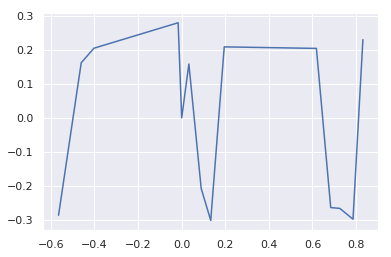

In [19]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

print(np.max(test_curve[:,0]))
print(np.max(test_curve[:,1]))

print(np.min(test_curve[:,0]))
print(np.min(test_curve[:,1]))
print(test_curve.shape)

ax = sns.lineplot(x=test_curve[0,:,0,0], y=test_curve[0,:,0,1])

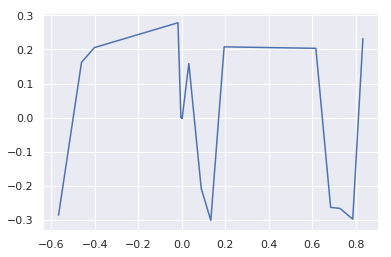

In [31]:
reload(pac_data)

new_X = pac_data.aug_data(data=X_train, white_noise_std=0.001)
test_curve = new_X[6000][np.newaxis]

ax = sns.lineplot(x=test_curve[0,:,0,0], y=test_curve[0,:,0,1])

In [32]:
ax = sns.lineplot(x=pred_curve[0,:,0,0], y=pred_curve[0,:,0,1])

NameError: name 'pred_curve' is not defined

In [123]:
X_T = X_train.reshape(-1, 24)
print(np.max(X_T, axis=0))

[0.99955589 1.         1.         1.         0.99981505 0.7348011
 0.08861734 1.         0.99627589 0.80688036 0.         1.
 0.99039466 0.82784742 0.         1.         0.99267971 0.83853669
 0.         1.         1.         0.85228403 0.         1.        ]


#  Confusion Matrix

In [19]:
X_train = net_input_data.X_train

res = model.adversarial_autoencoder.predict(X_train)

In [20]:
from operator import itemgetter

label_info.target_map.shape


counts = Counter(label_info.target_map)
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))

In [22]:
leb = res[2]
Ypred = np.argmax(leb, axis=1)
Ytest = np.argmax(label_info.Y, axis=1)
np.max(label_info.target_map)

13

In [23]:
leb[2][Ypred[2]]

0.9230431

In [24]:
Ytest
Ypred
labels
label_info.class_map

{6: 0,
 15: 1,
 16: 2,
 42: 3,
 52: 4,
 53: 5,
 62: 6,
 64: 7,
 65: 8,
 67: 9,
 88: 10,
 90: 11,
 92: 12,
 95: 13}

In [143]:
model.save()

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(Ytest, Ypred) #, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

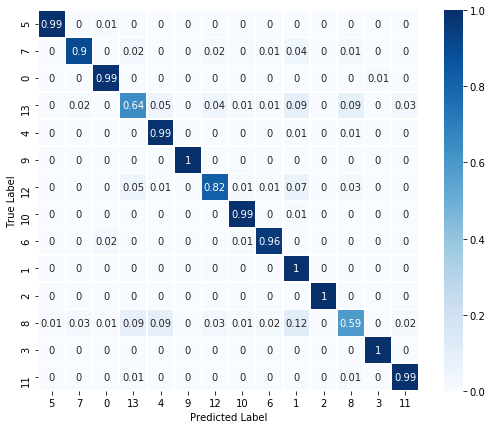

In [26]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')


In [119]:
from keras.callbacks import TensorBoard


In [120]:
build_model()
print(np.min(X_train[:,:,0,1]))
print(np.mean(X_train[:,:,0,1]))

(?, 9, 3, 8)
(?, 72, 6, 4)
-311.95863850764937
-0.0002671963098028612


In [21]:
y_count = Counter(target_map)
wtable = np.zeros((len(classes),))
for i in range(len(classes)):
    wtable[i] = y_count[i] / target_map.shape[0]

In [22]:
from keras.callbacks import TensorBoard

batch_size = 512
y_map = target_map
y_categorical = Y
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
start = time.time()
clfs = []
oof_preds = np.zeros((len(X_train_list[0]), len(classes)))
epochs = 10 #5000

for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint('./keras.model',monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    
    x_train, y_train = X_train[trn_], y_categorical[trn_]
    x_valid, y_valid = X_train[val_], y_categorical[val_]
    
    model = build_model()    
    
    model.compile(optimizer='adadelta', loss='binary_crossentropy')
        
    model.fit(x_train, x_train/660,
                    epochs=50,
                    batch_size=128,
                    shuffle=True,
                    validation_data=(x_valid, x_valid/660),
                    callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])



(?, 9, 3, 8)
(?, 72, 6, 4)
Train on 6274 samples, validate on 1574 samples
Epoch 1/50
6274/6274 [==============================] - 2s 397us/step - loss: 0.1698 - val_loss: 0.0035
Epoch 2/50
6274/6274 [==============================] - 2s 362us/step - loss: 0.0023 - val_loss: 0.0013
Epoch 3/50
6274/6274 [==============================] - 2s 367us/step - loss: 0.0011 - val_loss: 7.1935e-04
Epoch 4/50
6274/6274 [==============================] - 3s 426us/step - loss: 7.0056e-04 - val_loss: 5.0672e-04
Epoch 5/50
6274/6274 [==============================] - 2s 393us/step - loss: 5.6284e-04 - val_loss: 4.2567e-04
Epoch 6/50
6274/6274 [==============================] - 2s 351us/step - loss: 5.0986e-04 - val_loss: 3.9362e-04
Epoch 7/50
6274/6274 [==============================] - 2s 340us/step - loss: 4.8764e-04 - val_loss: 3.7878e-04
Epoch 8/50
6274/6274 [==============================] - 2s 342us/step - loss: 4.7654e-04 - val_loss: 3.7062e-04
Epoch 9/50
6274/6274 [===========================

KeyboardInterrupt: 

In [6]:
batch_size = 512
y_map = target_map
y_categorical = Y
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
start = time.time()
clfs = []
oof_preds = np.zeros((len(X_train_list[0]), len(classes)))
epochs = 10 #5000

for fold_, (trn_, val_) in enumerate(folds.split(y_map, y_map)):
    checkPoint = ModelCheckpoint('./keras.model',monitor='val_loss',mode = 'min', save_best_only=True, verbose=0)
    X0 = X_train_list[0]
    X1 = X_train_list[1]
    X2 = X_train_list[2]
    X3 = X_train_list[3]
    X4 = X_train_list[4]
    X5 = X_train_list[5]
    x_train0, x_train1, x_train2, x_train3, x_train4, x_train5, y_train = X0[trn_], X1[trn_], X2[trn_], X3[trn_], X4[trn_], X5[trn_], y_categorical[trn_]
    x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5, y_valid = X0[val_], X1[val_], X2[val_], X3[val_], X4[val_], X5[val_], y_categorical[val_]
    
    model = build_model()    
    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)#
    early_stopping = EarlyStopping(monitor='loss', patience=30, verbose=1)
    model.compile(loss=mywloss, optimizer=optimizer, metrics=['accuracy'])
    history = model.fit([x_train0, x_train1, x_train2, x_train3, x_train4, x_train5], y_train,
                    validation_data=[[x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5], y_valid], 
                    epochs=epochs,
                        batch_size=batch_size,
                    shuffle=True,verbose=1,callbacks=[checkPoint, early_stopping])      
    plot_loss_acc(history)
    
    print('Loading Best Model')
    model.load_weights('./keras.model')
    # # Get predicted probabilities for each class
    oof_preds[val_, :] = model.predict([x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5],batch_size=batch_size)
    print(multi_weighted_logloss(y_valid, model.predict([x_valid0, x_valid1, x_valid2, x_valid3, x_valid4, x_valid5],batch_size=batch_size)))
    clfs.append(model)
    
print('MULTI WEIGHTED LOG LOSS : %.5f ' % multi_weighted_logloss(y_categorical,oof_preds))

elapsed_time = time.time() - start
print("elapsed_time:", elapsed_time)

NameError: name 'target_map' is not defined

## Ideas for improvement
- Add one more input for metadata.
- Derive some features as timeseries and feed into the RNN?